In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and Prepare Data

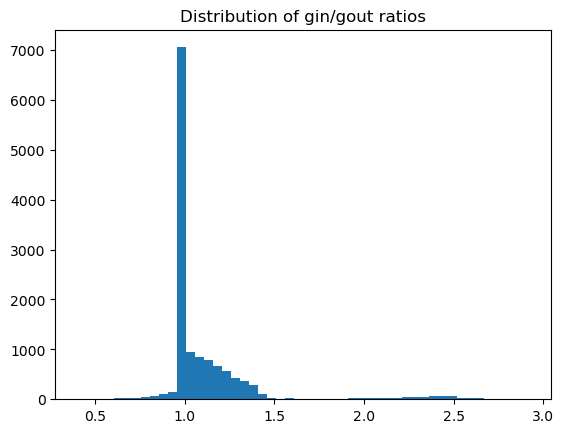

In [2]:
gin_gout_file = "Data/gin_gout_ratio.csv"  
df_features = pd.read_csv(gin_gout_file)


test_info_file = "Data/test_info.csv"  
df_labels = pd.read_csv(test_info_file)

# Extract Capacity (C) and Cross Traffic
C_values = df_labels.iloc[:, 0].values  # First column = Capacity (C)
cross_traffic_values = df_labels.iloc[:, 1].values  # Second column = Cross Traffic

# Compute Available Bandwidth (A = C - Cross Traffic)
A_values = C_values - cross_traffic_values

# Combine A and C as labels
y = np.column_stack((A_values, C_values))  # Shape: (num_samples, 2)

# Convert gin/gout ratio DataFrame to NumPy array
X = df_features.values  # Shape: (num_samples, num_features)

# Check dataset alignment
if len(X) != len(y):
    raise ValueError(f"Mismatch: gin_gout_ratio.csv has {len(X)} rows, test_info.csv has {len(y)} labels.")

# Normalize A and C values using MinMaxScaler
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)  # Scale (A, C) values between 0 and 1

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Plot data distribution to check if gin/gout ratios have useful variations
plt.hist(X.flatten(), bins=50)
plt.title("Distribution of gin/gout ratios")
plt.show()

# Build The Model

In [3]:
# Define the model (same as your `build_bandwidth_estimator`)
def build_bandwidth_estimator(k=25):
    model = keras.Sequential([
        layers.Input(shape=(k,)),  # Input layer (expects 20 features)
        layers.Dense(40, activation='relu'),  # Hidden layer with 40 neurons
        layers.Dense(2, activation='linear')  # Output layer (predicts A and C)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Ensure input dimension matches model expectation
k = X_train.shape[1]
model = build_bandwidth_estimator(k)
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 962 (3.76 KB)

 Trainable params: 962 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5137 - mae: 0.5918 - val_loss: 0.2272 - val_mae: 0.3775
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2131 - mae: 0.3609 - val_loss: 0.1819 - val_mae: 0.3772
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1708 - mae: 0.3713 - val_loss: 0.1768 - val_mae: 0.3856
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1657 - mae: 0.3693 - val_loss: 0.1728 - val_mae: 0.3703
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1619 - mae: 0.3588 - val_loss: 0.1685 - val_mae: 0.3652
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1607 - mae: 0.3582 - val_loss: 0.1660 - val_mae: 0.3633
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1515 - mae: 0.3433 - val_loss: 0.1652 - val_mae: 0.3592
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1553 - mae: 0.3475 - val_loss: 0.1616 - val_mae: 0.3549
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1495 - mae:

In [4]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict Available Bandwidth (A) and Capacity (C)
predictions = model.predict(X_test)
print("Predicted A and C values:\n", predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1189 - mae: 0.2736 
Test Loss: 0.10668281465768814, Test MAE: 0.2569030225276947
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Predicted A and C values:
 [[0.1916506  0.6958857 ]
 [0.20499557 0.56539416]
 [0.32168838 0.64655626]
 [0.5575617  0.6000273 ]
 [0.41628176 0.5388616 ]
 [0.29375526 0.793076  ]
 [0.3338592  0.23849092]
 [0.58655405 1.0672654 ]
 [0.16603068 0.6614    ]
 [0.58449006 0.7680151 ]
 [0.37475058 0.33001423]
 [0.57966536 0.7440935 ]
 [0.5432855  0.5971467 ]
 [0.5552328  0.4926591 ]
 [0.4548751  0.15577058]
 [0.63402915 0.7480577 ]
 [0.25239527 0.75904113]
 [0.31885183 0.94237465]
 [0.46001032 0.45173937]
 [0.19775778 0.7377104 ]
 [0.34192008 0.1698422 ]
 [0.75408465 1.132964  ]
 [0.5096777  0.30200064]
 [0.1310603  0.3471871 ]
 [0.12411408 0.45748645]
 [0.61345965 0.6666753 ]
 [0.35050517 0.19769944]
 [0.39391235 0.17830326]
 [0.15883403 0.49498612]
 [0.11883378 0.48740554]
 [0.36014786 0.10572906]
 [0.18153192 0.29081655]
 [0.226